In [1]:
# Import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchinfo
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import random

import os
from pathlib import Path
from typing import List

/Users/hakushi/miniconda3/envs/PyTorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a loader for torch tensors
def tensor_loader(path: Path) -> torch.Tensor:
    return torch.load(path).type(torch.FloatTensor).to(device)

In [3]:
class ProfessorXDataset(Dataset):
    def __init__(self, filename):
        encoder = LabelEncoder()

        df = pd.read_csv(filename, header=None)
        df.dropna(inplace=True)

        x = df.iloc[:, 1:]
        x = torch.from_numpy(x.values).unsqueeze(1).to(torch.float32)
        y = df.iloc[:, 0]
        encoder = LabelEncoder()
        encoder.fit(y)

        self.signals = x
        self.labels = torch.tensor(encoder.transform(y), dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

In [4]:
# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
df = ProfessorXDataset('Dataset_Cleaned/DATASET.csv')
# df.signals.T.shape
df.signals[0].shape, df.labels

(torch.Size([1, 50]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [6]:
# Split dataset into train-test with 80:20 ratio

generator = torch.manual_seed(420)  # Set seed for reproducible result
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data, test_data = torch.utils.data.random_split(
    dataset=df, lengths=[train_size, test_size], generator=generator
)

In [7]:
# Make train-test data into DataLoader (iterable)

BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    generator=generator,
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    generator=generator,
)

In [8]:
# Get a single signal and it's associated label
signal, label = next(iter(train_dataloader))
print(f"Signal shape: {signal.shape} -> [batch_size, channel, length]")
print(f"Label shape: {label.shape}")
label

Signal shape: torch.Size([4, 1, 50]) -> [batch_size, channel, length]
Label shape: torch.Size([4])


tensor([1, 0, 0, 0])

In [9]:
# Create a simple CNN model based on https://github.com/Sentdex/BCI/blob/master/training.py
class ProfessorXModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=2),
            torch.nn.ReLU(),
        )
        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )
        self.conv_block_3 = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=16*11, out_features=128),
            torch.nn.Linear(in_features=128, out_features=1),
            torch.nn.Sigmoid() # Sigmoid ensures the result is always between 0 and 1
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.conv_block_3(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        # return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

        # Data quality impact test
        snr = 1. # pick desired signal-to-noise ratio
        std = torch.std(x) # calculate standard deviation of x
        x += (2. * torch.rand(x.shape) - 1.) * 2. * std * snr

        result = self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))
        return torch.squeeze(result) # remove the extraneous size 1 dimension
                                     # from the output size, leaving only the
                                     # making the final output 1D


In [10]:
torch.manual_seed(420)
model = ProfessorXModel()
model

ProfessorXModel(
  (conv_block_1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=176, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [11]:
# Test model with a single signal
signal_batch, label_batch = next(iter(train_dataloader))
signal_batch.shape, label_batch.shape
signal_batch.dtype, label_batch.dtype

(torch.float32, torch.int64)

In [12]:
model(signal_batch)

tensor([0.1415, 0.0123, 0.4423, 0.0339], grad_fn=<SqueezeBackward0>)

In [13]:
# Check summary of model
torchinfo.summary(model, input_size=[4, 1, 50])

/Users/hakushi/miniconda3/envs/PyTorch/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/hakushi/miniconda3/envs/PyTorch/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ProfessorXModel                          [4]                       --
├─Sequential: 1-1                        [4, 16, 47]               --
│    └─Conv1d: 2-1                       [4, 16, 48]               64
│    └─ReLU: 2-2                         [4, 16, 48]               --
│    └─Conv1d: 2-3                       [4, 16, 47]               528
│    └─ReLU: 2-4                         [4, 16, 47]               --
├─Sequential: 1-2                        [4, 16, 23]               --
│    └─Conv1d: 2-5                       [4, 16, 46]               528
│    └─ReLU: 2-6                         [4, 16, 46]               --
│    └─MaxPool1d: 2-7                    [4, 16, 23]               --
├─Sequential: 1-3                        [4, 16, 11]               --
│    └─Conv1d: 2-8                       [4, 16, 22]               528
│    └─ReLU: 2-9                         [4, 16, 22]               --
│    └─MaxPo

In [14]:
# Create a train loop and test loop
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device=device,
):
    # Put model in train mode
    model.train()

    # Setup train loss and accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # convert labels from long int to fp32, matching the model output
        y = y.to(torch.float32)

        # Forward propagation
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad (reset)
        optimizer.zero_grad()

        # Backward propagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.lt((y_pred - y).abs(), torch.tensor([0.5,]))
        train_acc += y_pred_class.sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [15]:
# Create a test loop
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device
):
    # Put model into evaluation mode
    model.eval()

    # Setup test loss, test acc
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through data loader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # convert labels from long int to fp32, matching the model output
            y = y.to(torch.float32)

            # Forward propagation
            test_pred_logits = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            # test_pred_labels = test_pred_logits.argmax(dim=1)
            # test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
            test_pred_labels = torch.lt((test_pred_logits - y).abs(), torch.tensor([0.5,]))
            test_acc += test_pred_labels.sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [16]:
# Create train function that combines train_loop and test_loop
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
    epochs: int = 5,
    device=device
):
    # Create empty result dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # Loop through train and test for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Print what's happening
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [17]:
# Set random seeds
torch.manual_seed(420)
torch.cuda.manual_seed(420)

# Set number of epochs
NUM_EPOCHS = 400

# Create an instance of the model
model = ProfessorXModel().to(device)

# Setup a loss function and optimizer
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.0000001
    # Lowering the learning rate slows down model convergence
    # params=model.parameters(), lr=0.000001
    )

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

end_time = timer()
print(f"\nTotal training time: {start_time - end_time:.2f} seconds")

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 2/400 [00:00<01:21,  4.90it/s]

Epoch: 0 | Train Loss: 1.0380, Train Accuracy: 0.4939 | Test Loss: 1.1041, Test Accuracy: 0.4539
Epoch: 1 | Train Loss: 1.0592, Train Accuracy: 0.4586 | Test Loss: 1.2246, Test Accuracy: 0.3750


  1%|          | 4/400 [00:00<01:10,  5.59it/s]

Epoch: 2 | Train Loss: 1.0264, Train Accuracy: 0.4890 | Test Loss: 1.2541, Test Accuracy: 0.4145
Epoch: 3 | Train Loss: 1.0582, Train Accuracy: 0.4724 | Test Loss: 1.1643, Test Accuracy: 0.4232


  2%|▏         | 6/400 [00:01<01:06,  5.88it/s]

Epoch: 4 | Train Loss: 1.0287, Train Accuracy: 0.4983 | Test Loss: 1.0900, Test Accuracy: 0.4671
Epoch: 5 | Train Loss: 1.0164, Train Accuracy: 0.5138 | Test Loss: 1.1549, Test Accuracy: 0.4232


  2%|▏         | 8/400 [00:01<01:07,  5.83it/s]

Epoch: 6 | Train Loss: 0.9914, Train Accuracy: 0.5011 | Test Loss: 1.1652, Test Accuracy: 0.4496
Epoch: 7 | Train Loss: 1.0320, Train Accuracy: 0.5006 | Test Loss: 1.1097, Test Accuracy: 0.4342


  2%|▎         | 10/400 [00:01<01:06,  5.91it/s]

Epoch: 8 | Train Loss: 0.9912, Train Accuracy: 0.5331 | Test Loss: 1.1212, Test Accuracy: 0.4539
Epoch: 9 | Train Loss: 1.0317, Train Accuracy: 0.4823 | Test Loss: 1.1159, Test Accuracy: 0.4781


  3%|▎         | 12/400 [00:02<01:04,  6.02it/s]

Epoch: 10 | Train Loss: 0.9594, Train Accuracy: 0.5326 | Test Loss: 1.1901, Test Accuracy: 0.4298
Epoch: 11 | Train Loss: 0.9876, Train Accuracy: 0.5044 | Test Loss: 1.2690, Test Accuracy: 0.4035


  4%|▎         | 14/400 [00:02<01:06,  5.79it/s]

Epoch: 12 | Train Loss: 0.9824, Train Accuracy: 0.5552 | Test Loss: 1.0863, Test Accuracy: 0.4276
Epoch: 13 | Train Loss: 0.9544, Train Accuracy: 0.5442 | Test Loss: 1.1372, Test Accuracy: 0.3925


  4%|▍         | 16/400 [00:02<01:04,  5.95it/s]

Epoch: 14 | Train Loss: 0.9899, Train Accuracy: 0.5132 | Test Loss: 1.0880, Test Accuracy: 0.4583
Epoch: 15 | Train Loss: 0.9754, Train Accuracy: 0.5304 | Test Loss: 1.1303, Test Accuracy: 0.4232


  4%|▍         | 18/400 [00:03<01:03,  6.04it/s]

Epoch: 16 | Train Loss: 1.0070, Train Accuracy: 0.5193 | Test Loss: 1.1859, Test Accuracy: 0.4518
Epoch: 17 | Train Loss: 0.9668, Train Accuracy: 0.5392 | Test Loss: 1.0236, Test Accuracy: 0.4846


  5%|▌         | 20/400 [00:03<01:02,  6.07it/s]

Epoch: 18 | Train Loss: 0.9876, Train Accuracy: 0.5265 | Test Loss: 1.1975, Test Accuracy: 0.4189
Epoch: 19 | Train Loss: 0.9396, Train Accuracy: 0.5640 | Test Loss: 1.0494, Test Accuracy: 0.4518


  6%|▌         | 22/400 [00:03<01:01,  6.12it/s]

Epoch: 20 | Train Loss: 0.9215, Train Accuracy: 0.5773 | Test Loss: 1.1360, Test Accuracy: 0.4320
Epoch: 21 | Train Loss: 0.9600, Train Accuracy: 0.5491 | Test Loss: 1.0468, Test Accuracy: 0.5395


  6%|▌         | 24/400 [00:04<01:01,  6.13it/s]

Epoch: 22 | Train Loss: 0.9254, Train Accuracy: 0.5557 | Test Loss: 1.0631, Test Accuracy: 0.4978
Epoch: 23 | Train Loss: 0.9656, Train Accuracy: 0.5557 | Test Loss: 1.0524, Test Accuracy: 0.5132


  6%|▋         | 26/400 [00:04<01:02,  5.97it/s]

Epoch: 24 | Train Loss: 0.9245, Train Accuracy: 0.5563 | Test Loss: 0.9414, Test Accuracy: 0.5658
Epoch: 25 | Train Loss: 0.9303, Train Accuracy: 0.5568 | Test Loss: 1.0152, Test Accuracy: 0.5000


  7%|▋         | 28/400 [00:04<01:02,  5.98it/s]

Epoch: 26 | Train Loss: 0.9661, Train Accuracy: 0.5326 | Test Loss: 1.0362, Test Accuracy: 0.5066
Epoch: 27 | Train Loss: 0.9170, Train Accuracy: 0.5734 | Test Loss: 1.0389, Test Accuracy: 0.5461


  8%|▊         | 30/400 [00:05<01:00,  6.07it/s]

Epoch: 28 | Train Loss: 0.9111, Train Accuracy: 0.5745 | Test Loss: 1.0138, Test Accuracy: 0.5241
Epoch: 29 | Train Loss: 0.9200, Train Accuracy: 0.5751 | Test Loss: 1.0176, Test Accuracy: 0.5263


  8%|▊         | 32/400 [00:05<01:00,  6.11it/s]

Epoch: 30 | Train Loss: 0.9006, Train Accuracy: 0.5690 | Test Loss: 1.0228, Test Accuracy: 0.4781
Epoch: 31 | Train Loss: 0.8923, Train Accuracy: 0.5657 | Test Loss: 0.9858, Test Accuracy: 0.5132


  8%|▊         | 34/400 [00:05<00:59,  6.13it/s]

Epoch: 32 | Train Loss: 0.9171, Train Accuracy: 0.5789 | Test Loss: 0.9838, Test Accuracy: 0.5395
Epoch: 33 | Train Loss: 0.9221, Train Accuracy: 0.5552 | Test Loss: 1.0200, Test Accuracy: 0.5197


  9%|▉         | 36/400 [00:06<00:59,  6.09it/s]

Epoch: 34 | Train Loss: 0.9016, Train Accuracy: 0.5944 | Test Loss: 0.9762, Test Accuracy: 0.5329
Epoch: 35 | Train Loss: 0.8890, Train Accuracy: 0.5855 | Test Loss: 1.0184, Test Accuracy: 0.5175


 10%|▉         | 38/400 [00:06<00:59,  6.12it/s]

Epoch: 36 | Train Loss: 0.8918, Train Accuracy: 0.5784 | Test Loss: 0.9742, Test Accuracy: 0.5439
Epoch: 37 | Train Loss: 0.8454, Train Accuracy: 0.6087 | Test Loss: 0.9995, Test Accuracy: 0.5373


 10%|█         | 40/400 [00:06<01:00,  5.96it/s]

Epoch: 38 | Train Loss: 0.8975, Train Accuracy: 0.5955 | Test Loss: 0.9757, Test Accuracy: 0.5197
Epoch: 39 | Train Loss: 0.8607, Train Accuracy: 0.6093 | Test Loss: 0.9902, Test Accuracy: 0.5307


 10%|█         | 42/400 [00:07<00:59,  5.97it/s]

Epoch: 40 | Train Loss: 0.8581, Train Accuracy: 0.5889 | Test Loss: 1.0326, Test Accuracy: 0.5088
Epoch: 41 | Train Loss: 0.8765, Train Accuracy: 0.5933 | Test Loss: 0.9724, Test Accuracy: 0.5373


 11%|█         | 44/400 [00:07<00:59,  6.02it/s]

Epoch: 42 | Train Loss: 0.8369, Train Accuracy: 0.5883 | Test Loss: 0.9439, Test Accuracy: 0.5592
Epoch: 43 | Train Loss: 0.8636, Train Accuracy: 0.5971 | Test Loss: 0.9498, Test Accuracy: 0.5066


 12%|█▏        | 46/400 [00:07<00:59,  5.93it/s]

Epoch: 44 | Train Loss: 0.8520, Train Accuracy: 0.6032 | Test Loss: 0.9430, Test Accuracy: 0.5373
Epoch: 45 | Train Loss: 0.8505, Train Accuracy: 0.6209 | Test Loss: 0.9816, Test Accuracy: 0.5570


 12%|█▏        | 48/400 [00:08<01:00,  5.82it/s]

Epoch: 46 | Train Loss: 0.8365, Train Accuracy: 0.6060 | Test Loss: 0.9247, Test Accuracy: 0.5811
Epoch: 47 | Train Loss: 0.8168, Train Accuracy: 0.6043 | Test Loss: 0.9045, Test Accuracy: 0.5526


 12%|█▎        | 50/400 [00:08<00:58,  5.98it/s]

Epoch: 48 | Train Loss: 0.8218, Train Accuracy: 0.6082 | Test Loss: 0.9588, Test Accuracy: 0.5526
Epoch: 49 | Train Loss: 0.8170, Train Accuracy: 0.6120 | Test Loss: 0.8654, Test Accuracy: 0.5570


 13%|█▎        | 52/400 [00:08<00:58,  5.92it/s]

Epoch: 50 | Train Loss: 0.8219, Train Accuracy: 0.6198 | Test Loss: 0.9449, Test Accuracy: 0.5132
Epoch: 51 | Train Loss: 0.8157, Train Accuracy: 0.6076 | Test Loss: 0.9102, Test Accuracy: 0.5636


 14%|█▎        | 54/400 [00:09<00:58,  5.94it/s]

Epoch: 52 | Train Loss: 0.8255, Train Accuracy: 0.6192 | Test Loss: 0.8810, Test Accuracy: 0.5921
Epoch: 53 | Train Loss: 0.8129, Train Accuracy: 0.6159 | Test Loss: 0.8981, Test Accuracy: 0.5439


 14%|█▍        | 56/400 [00:09<00:57,  5.94it/s]

Epoch: 54 | Train Loss: 0.8162, Train Accuracy: 0.6192 | Test Loss: 0.8422, Test Accuracy: 0.5833
Epoch: 55 | Train Loss: 0.8111, Train Accuracy: 0.6264 | Test Loss: 0.8808, Test Accuracy: 0.5768


 14%|█▍        | 58/400 [00:09<00:59,  5.73it/s]

Epoch: 56 | Train Loss: 0.7823, Train Accuracy: 0.6159 | Test Loss: 0.8738, Test Accuracy: 0.5504
Epoch: 57 | Train Loss: 0.7598, Train Accuracy: 0.6325 | Test Loss: 0.9194, Test Accuracy: 0.5855


 15%|█▌        | 60/400 [00:10<00:58,  5.78it/s]

Epoch: 58 | Train Loss: 0.7621, Train Accuracy: 0.6385 | Test Loss: 0.8679, Test Accuracy: 0.6053
Epoch: 59 | Train Loss: 0.7635, Train Accuracy: 0.6198 | Test Loss: 0.8818, Test Accuracy: 0.5921


 16%|█▌        | 62/400 [00:10<00:57,  5.91it/s]

Epoch: 60 | Train Loss: 0.7450, Train Accuracy: 0.6556 | Test Loss: 0.9445, Test Accuracy: 0.5636
Epoch: 61 | Train Loss: 0.7848, Train Accuracy: 0.6148 | Test Loss: 0.8453, Test Accuracy: 0.5965


 16%|█▌        | 64/400 [00:10<00:59,  5.66it/s]

Epoch: 62 | Train Loss: 0.7727, Train Accuracy: 0.6258 | Test Loss: 0.8466, Test Accuracy: 0.5702
Epoch: 63 | Train Loss: 0.7413, Train Accuracy: 0.6567 | Test Loss: 0.7782, Test Accuracy: 0.6053


 16%|█▋        | 66/400 [00:11<00:57,  5.77it/s]

Epoch: 64 | Train Loss: 0.7305, Train Accuracy: 0.6402 | Test Loss: 0.8195, Test Accuracy: 0.5921
Epoch: 65 | Train Loss: 0.7747, Train Accuracy: 0.6269 | Test Loss: 0.8444, Test Accuracy: 0.5482


 17%|█▋        | 68/400 [00:11<00:56,  5.88it/s]

Epoch: 66 | Train Loss: 0.7472, Train Accuracy: 0.6435 | Test Loss: 0.8678, Test Accuracy: 0.5921
Epoch: 67 | Train Loss: 0.7106, Train Accuracy: 0.6634 | Test Loss: 0.8105, Test Accuracy: 0.5921


 18%|█▊        | 70/400 [00:11<00:56,  5.88it/s]

Epoch: 68 | Train Loss: 0.7422, Train Accuracy: 0.6341 | Test Loss: 0.8799, Test Accuracy: 0.5417
Epoch: 69 | Train Loss: 0.7206, Train Accuracy: 0.6667 | Test Loss: 0.7653, Test Accuracy: 0.6711


 18%|█▊        | 72/400 [00:12<00:55,  5.91it/s]

Epoch: 70 | Train Loss: 0.7363, Train Accuracy: 0.6490 | Test Loss: 0.8099, Test Accuracy: 0.6272
Epoch: 71 | Train Loss: 0.7352, Train Accuracy: 0.6402 | Test Loss: 0.7928, Test Accuracy: 0.6184


 18%|█▊        | 74/400 [00:12<00:55,  5.87it/s]

Epoch: 72 | Train Loss: 0.7386, Train Accuracy: 0.6336 | Test Loss: 0.7923, Test Accuracy: 0.6053
Epoch: 73 | Train Loss: 0.7339, Train Accuracy: 0.6402 | Test Loss: 0.8880, Test Accuracy: 0.5702


 19%|█▉        | 76/400 [00:12<00:54,  5.94it/s]

Epoch: 74 | Train Loss: 0.7456, Train Accuracy: 0.6435 | Test Loss: 0.8360, Test Accuracy: 0.5921
Epoch: 75 | Train Loss: 0.7096, Train Accuracy: 0.6606 | Test Loss: 0.7729, Test Accuracy: 0.6579


 20%|█▉        | 78/400 [00:13<00:54,  5.91it/s]

Epoch: 76 | Train Loss: 0.7192, Train Accuracy: 0.6336 | Test Loss: 0.7589, Test Accuracy: 0.6096
Epoch: 77 | Train Loss: 0.7015, Train Accuracy: 0.6606 | Test Loss: 0.7431, Test Accuracy: 0.6491


 20%|█▉        | 79/400 [00:13<00:54,  5.91it/s]

Epoch: 78 | Train Loss: 0.6990, Train Accuracy: 0.6534 | Test Loss: 0.7973, Test Accuracy: 0.5833


 20%|██        | 81/400 [00:13<00:56,  5.62it/s]

Epoch: 79 | Train Loss: 0.6983, Train Accuracy: 0.6821 | Test Loss: 0.7228, Test Accuracy: 0.6447
Epoch: 80 | Train Loss: 0.6822, Train Accuracy: 0.6810 | Test Loss: 0.7176, Test Accuracy: 0.6382


 21%|██        | 83/400 [00:14<00:54,  5.79it/s]

Epoch: 81 | Train Loss: 0.6709, Train Accuracy: 0.6783 | Test Loss: 0.7771, Test Accuracy: 0.6053
Epoch: 82 | Train Loss: 0.7028, Train Accuracy: 0.6457 | Test Loss: 0.7754, Test Accuracy: 0.6250


 21%|██▏       | 85/400 [00:14<00:55,  5.67it/s]

Epoch: 83 | Train Loss: 0.6541, Train Accuracy: 0.6777 | Test Loss: 0.7671, Test Accuracy: 0.6053
Epoch: 84 | Train Loss: 0.6652, Train Accuracy: 0.6689 | Test Loss: 0.7356, Test Accuracy: 0.5965


 22%|██▏       | 87/400 [00:14<00:54,  5.73it/s]

Epoch: 85 | Train Loss: 0.6844, Train Accuracy: 0.6816 | Test Loss: 0.6946, Test Accuracy: 0.6382
Epoch: 86 | Train Loss: 0.6746, Train Accuracy: 0.6716 | Test Loss: 0.7367, Test Accuracy: 0.5855


 22%|██▏       | 89/400 [00:15<00:52,  5.88it/s]

Epoch: 87 | Train Loss: 0.6503, Train Accuracy: 0.6932 | Test Loss: 0.6984, Test Accuracy: 0.6645
Epoch: 88 | Train Loss: 0.6639, Train Accuracy: 0.6374 | Test Loss: 0.7471, Test Accuracy: 0.6118


 23%|██▎       | 91/400 [00:15<00:52,  5.94it/s]

Epoch: 89 | Train Loss: 0.6539, Train Accuracy: 0.6766 | Test Loss: 0.7040, Test Accuracy: 0.6140
Epoch: 90 | Train Loss: 0.6562, Train Accuracy: 0.6893 | Test Loss: 0.7344, Test Accuracy: 0.6184


 23%|██▎       | 93/400 [00:15<00:53,  5.70it/s]

Epoch: 91 | Train Loss: 0.6408, Train Accuracy: 0.6832 | Test Loss: 0.6951, Test Accuracy: 0.6447
Epoch: 92 | Train Loss: 0.6617, Train Accuracy: 0.6921 | Test Loss: 0.7321, Test Accuracy: 0.5855


 24%|██▍       | 95/400 [00:16<00:53,  5.75it/s]

Epoch: 93 | Train Loss: 0.6257, Train Accuracy: 0.7003 | Test Loss: 0.6724, Test Accuracy: 0.6601
Epoch: 94 | Train Loss: 0.6426, Train Accuracy: 0.6904 | Test Loss: 0.7236, Test Accuracy: 0.5987


 24%|██▍       | 97/400 [00:16<00:51,  5.87it/s]

Epoch: 95 | Train Loss: 0.6403, Train Accuracy: 0.6954 | Test Loss: 0.7201, Test Accuracy: 0.6228
Epoch: 96 | Train Loss: 0.6141, Train Accuracy: 0.7047 | Test Loss: 0.6936, Test Accuracy: 0.6425


 25%|██▍       | 99/400 [00:16<00:51,  5.88it/s]

Epoch: 97 | Train Loss: 0.6211, Train Accuracy: 0.6954 | Test Loss: 0.7349, Test Accuracy: 0.6031
Epoch: 98 | Train Loss: 0.6148, Train Accuracy: 0.6882 | Test Loss: 0.7277, Test Accuracy: 0.6382


 25%|██▌       | 101/400 [00:17<00:50,  5.91it/s]

Epoch: 99 | Train Loss: 0.6104, Train Accuracy: 0.6932 | Test Loss: 0.6932, Test Accuracy: 0.6184
Epoch: 100 | Train Loss: 0.6219, Train Accuracy: 0.6893 | Test Loss: 0.7013, Test Accuracy: 0.6250


 26%|██▌       | 103/400 [00:17<00:50,  5.91it/s]

Epoch: 101 | Train Loss: 0.5928, Train Accuracy: 0.6998 | Test Loss: 0.7603, Test Accuracy: 0.6053
Epoch: 102 | Train Loss: 0.5956, Train Accuracy: 0.7086 | Test Loss: 0.6840, Test Accuracy: 0.6228


 26%|██▋       | 105/400 [00:17<00:50,  5.90it/s]

Epoch: 103 | Train Loss: 0.6115, Train Accuracy: 0.6992 | Test Loss: 0.6729, Test Accuracy: 0.6382
Epoch: 104 | Train Loss: 0.5874, Train Accuracy: 0.7147 | Test Loss: 0.6648, Test Accuracy: 0.6689


 27%|██▋       | 107/400 [00:18<00:49,  5.93it/s]

Epoch: 105 | Train Loss: 0.5825, Train Accuracy: 0.7014 | Test Loss: 0.6772, Test Accuracy: 0.6513
Epoch: 106 | Train Loss: 0.5824, Train Accuracy: 0.7014 | Test Loss: 0.6870, Test Accuracy: 0.6316


 27%|██▋       | 109/400 [00:18<00:49,  5.93it/s]

Epoch: 107 | Train Loss: 0.6034, Train Accuracy: 0.6932 | Test Loss: 0.7024, Test Accuracy: 0.6447
Epoch: 108 | Train Loss: 0.5827, Train Accuracy: 0.6915 | Test Loss: 0.6425, Test Accuracy: 0.6711


 28%|██▊       | 111/400 [00:18<00:49,  5.80it/s]

Epoch: 109 | Train Loss: 0.5779, Train Accuracy: 0.7119 | Test Loss: 0.6165, Test Accuracy: 0.6491
Epoch: 110 | Train Loss: 0.5598, Train Accuracy: 0.7185 | Test Loss: 0.6189, Test Accuracy: 0.7281


 28%|██▊       | 113/400 [00:19<00:48,  5.89it/s]

Epoch: 111 | Train Loss: 0.5799, Train Accuracy: 0.7036 | Test Loss: 0.6784, Test Accuracy: 0.6711
Epoch: 112 | Train Loss: 0.5805, Train Accuracy: 0.7158 | Test Loss: 0.5875, Test Accuracy: 0.6908


 29%|██▉       | 115/400 [00:19<00:48,  5.93it/s]

Epoch: 113 | Train Loss: 0.5553, Train Accuracy: 0.7384 | Test Loss: 0.6194, Test Accuracy: 0.6776
Epoch: 114 | Train Loss: 0.5769, Train Accuracy: 0.7169 | Test Loss: 0.6128, Test Accuracy: 0.6732


 29%|██▉       | 117/400 [00:19<00:47,  5.95it/s]

Epoch: 115 | Train Loss: 0.5553, Train Accuracy: 0.7263 | Test Loss: 0.5823, Test Accuracy: 0.6908
Epoch: 116 | Train Loss: 0.5381, Train Accuracy: 0.7334 | Test Loss: 0.5974, Test Accuracy: 0.7434


 30%|██▉       | 119/400 [00:20<00:47,  5.97it/s]

Epoch: 117 | Train Loss: 0.5599, Train Accuracy: 0.7163 | Test Loss: 0.6307, Test Accuracy: 0.6908
Epoch: 118 | Train Loss: 0.5606, Train Accuracy: 0.7136 | Test Loss: 0.6601, Test Accuracy: 0.6711


 30%|███       | 121/400 [00:20<00:46,  5.95it/s]

Epoch: 119 | Train Loss: 0.5584, Train Accuracy: 0.7213 | Test Loss: 0.6530, Test Accuracy: 0.6886
Epoch: 120 | Train Loss: 0.5399, Train Accuracy: 0.7379 | Test Loss: 0.6125, Test Accuracy: 0.6689


 31%|███       | 123/400 [00:20<00:46,  5.96it/s]

Epoch: 121 | Train Loss: 0.5474, Train Accuracy: 0.7180 | Test Loss: 0.6194, Test Accuracy: 0.6623
Epoch: 122 | Train Loss: 0.5353, Train Accuracy: 0.7368 | Test Loss: 0.6075, Test Accuracy: 0.6908


 31%|███▏      | 125/400 [00:21<00:46,  5.96it/s]

Epoch: 123 | Train Loss: 0.5216, Train Accuracy: 0.7528 | Test Loss: 0.5738, Test Accuracy: 0.6732
Epoch: 124 | Train Loss: 0.5568, Train Accuracy: 0.7064 | Test Loss: 0.5394, Test Accuracy: 0.7215


 32%|███▏      | 127/400 [00:21<00:45,  5.99it/s]

Epoch: 125 | Train Loss: 0.5225, Train Accuracy: 0.7483 | Test Loss: 0.6254, Test Accuracy: 0.7105
Epoch: 126 | Train Loss: 0.5434, Train Accuracy: 0.7296 | Test Loss: 0.5406, Test Accuracy: 0.6886


 32%|███▏      | 129/400 [00:21<00:46,  5.84it/s]

Epoch: 127 | Train Loss: 0.5253, Train Accuracy: 0.7450 | Test Loss: 0.5721, Test Accuracy: 0.6689
Epoch: 128 | Train Loss: 0.5043, Train Accuracy: 0.7285 | Test Loss: 0.5689, Test Accuracy: 0.6667


 33%|███▎      | 131/400 [00:22<00:45,  5.93it/s]

Epoch: 129 | Train Loss: 0.5242, Train Accuracy: 0.7478 | Test Loss: 0.5795, Test Accuracy: 0.6820
Epoch: 130 | Train Loss: 0.5068, Train Accuracy: 0.7445 | Test Loss: 0.5726, Test Accuracy: 0.6908


 33%|███▎      | 133/400 [00:22<00:44,  5.95it/s]

Epoch: 131 | Train Loss: 0.4757, Train Accuracy: 0.7599 | Test Loss: 0.5254, Test Accuracy: 0.7039
Epoch: 132 | Train Loss: 0.5194, Train Accuracy: 0.7329 | Test Loss: 0.5742, Test Accuracy: 0.6842


 34%|███▍      | 135/400 [00:22<00:44,  5.97it/s]

Epoch: 133 | Train Loss: 0.5045, Train Accuracy: 0.7632 | Test Loss: 0.5347, Test Accuracy: 0.7149
Epoch: 134 | Train Loss: 0.5169, Train Accuracy: 0.7290 | Test Loss: 0.5562, Test Accuracy: 0.7368


 34%|███▍      | 137/400 [00:23<00:43,  5.98it/s]

Epoch: 135 | Train Loss: 0.4713, Train Accuracy: 0.7649 | Test Loss: 0.5556, Test Accuracy: 0.6776
Epoch: 136 | Train Loss: 0.4926, Train Accuracy: 0.7445 | Test Loss: 0.5788, Test Accuracy: 0.7018


 35%|███▍      | 139/400 [00:23<00:43,  6.00it/s]

Epoch: 137 | Train Loss: 0.4781, Train Accuracy: 0.7599 | Test Loss: 0.5959, Test Accuracy: 0.6425
Epoch: 138 | Train Loss: 0.4731, Train Accuracy: 0.7594 | Test Loss: 0.5528, Test Accuracy: 0.7281


 35%|███▌      | 141/400 [00:23<00:43,  5.91it/s]

Epoch: 139 | Train Loss: 0.4575, Train Accuracy: 0.7748 | Test Loss: 0.5249, Test Accuracy: 0.7434
Epoch: 140 | Train Loss: 0.4629, Train Accuracy: 0.7826 | Test Loss: 0.5362, Test Accuracy: 0.7171


 36%|███▌      | 143/400 [00:24<00:43,  5.96it/s]

Epoch: 141 | Train Loss: 0.4723, Train Accuracy: 0.7693 | Test Loss: 0.5324, Test Accuracy: 0.7105
Epoch: 142 | Train Loss: 0.4649, Train Accuracy: 0.7627 | Test Loss: 0.5602, Test Accuracy: 0.7149


 36%|███▋      | 145/400 [00:24<00:42,  5.97it/s]

Epoch: 143 | Train Loss: 0.4682, Train Accuracy: 0.7798 | Test Loss: 0.4904, Test Accuracy: 0.7500
Epoch: 144 | Train Loss: 0.4750, Train Accuracy: 0.7561 | Test Loss: 0.5232, Test Accuracy: 0.7215


 37%|███▋      | 147/400 [00:24<00:43,  5.81it/s]

Epoch: 145 | Train Loss: 0.4460, Train Accuracy: 0.7903 | Test Loss: 0.5054, Test Accuracy: 0.7434
Epoch: 146 | Train Loss: 0.4717, Train Accuracy: 0.7550 | Test Loss: 0.5213, Test Accuracy: 0.7368


 37%|███▋      | 149/400 [00:25<00:42,  5.89it/s]

Epoch: 147 | Train Loss: 0.4521, Train Accuracy: 0.7826 | Test Loss: 0.5049, Test Accuracy: 0.7237
Epoch: 148 | Train Loss: 0.4565, Train Accuracy: 0.7864 | Test Loss: 0.4514, Test Accuracy: 0.7346


 38%|███▊      | 151/400 [00:25<00:41,  5.94it/s]

Epoch: 149 | Train Loss: 0.4501, Train Accuracy: 0.7715 | Test Loss: 0.4910, Test Accuracy: 0.7368
Epoch: 150 | Train Loss: 0.4426, Train Accuracy: 0.7715 | Test Loss: 0.4861, Test Accuracy: 0.7412


 38%|███▊      | 153/400 [00:25<00:41,  5.95it/s]

Epoch: 151 | Train Loss: 0.4597, Train Accuracy: 0.7848 | Test Loss: 0.4533, Test Accuracy: 0.7697
Epoch: 152 | Train Loss: 0.4282, Train Accuracy: 0.8162 | Test Loss: 0.4583, Test Accuracy: 0.7829


 39%|███▉      | 155/400 [00:26<00:41,  5.95it/s]

Epoch: 153 | Train Loss: 0.4309, Train Accuracy: 0.8024 | Test Loss: 0.4835, Test Accuracy: 0.7807
Epoch: 154 | Train Loss: 0.4464, Train Accuracy: 0.7969 | Test Loss: 0.4967, Test Accuracy: 0.7237


 39%|███▉      | 157/400 [00:26<00:40,  5.97it/s]

Epoch: 155 | Train Loss: 0.4404, Train Accuracy: 0.7792 | Test Loss: 0.4772, Test Accuracy: 0.7303
Epoch: 156 | Train Loss: 0.4259, Train Accuracy: 0.7859 | Test Loss: 0.4246, Test Accuracy: 0.8289


 40%|███▉      | 159/400 [00:26<00:40,  5.97it/s]

Epoch: 157 | Train Loss: 0.4205, Train Accuracy: 0.7953 | Test Loss: 0.4523, Test Accuracy: 0.7939
Epoch: 158 | Train Loss: 0.4156, Train Accuracy: 0.8140 | Test Loss: 0.5004, Test Accuracy: 0.7632


 40%|████      | 161/400 [00:27<00:40,  5.97it/s]

Epoch: 159 | Train Loss: 0.4248, Train Accuracy: 0.8046 | Test Loss: 0.5280, Test Accuracy: 0.7171
Epoch: 160 | Train Loss: 0.4149, Train Accuracy: 0.8079 | Test Loss: 0.4311, Test Accuracy: 0.7632


 41%|████      | 163/400 [00:27<00:40,  5.82it/s]

Epoch: 161 | Train Loss: 0.4277, Train Accuracy: 0.7930 | Test Loss: 0.4545, Test Accuracy: 0.7807
Epoch: 162 | Train Loss: 0.4154, Train Accuracy: 0.8096 | Test Loss: 0.4238, Test Accuracy: 0.7610


 41%|████▏     | 165/400 [00:27<00:39,  5.89it/s]

Epoch: 163 | Train Loss: 0.4193, Train Accuracy: 0.8063 | Test Loss: 0.4829, Test Accuracy: 0.7675
Epoch: 164 | Train Loss: 0.4191, Train Accuracy: 0.8140 | Test Loss: 0.4319, Test Accuracy: 0.7829


 42%|████▏     | 167/400 [00:28<00:39,  5.94it/s]

Epoch: 165 | Train Loss: 0.3906, Train Accuracy: 0.8256 | Test Loss: 0.3884, Test Accuracy: 0.8026
Epoch: 166 | Train Loss: 0.4118, Train Accuracy: 0.8008 | Test Loss: 0.4403, Test Accuracy: 0.8026


 42%|████▏     | 169/400 [00:28<00:38,  5.96it/s]

Epoch: 167 | Train Loss: 0.3806, Train Accuracy: 0.8361 | Test Loss: 0.4504, Test Accuracy: 0.7829
Epoch: 168 | Train Loss: 0.3737, Train Accuracy: 0.8526 | Test Loss: 0.4696, Test Accuracy: 0.7675


 43%|████▎     | 171/400 [00:28<00:38,  5.96it/s]

Epoch: 169 | Train Loss: 0.3948, Train Accuracy: 0.8262 | Test Loss: 0.4337, Test Accuracy: 0.7697
Epoch: 170 | Train Loss: 0.3934, Train Accuracy: 0.8256 | Test Loss: 0.4439, Test Accuracy: 0.7961


 43%|████▎     | 173/400 [00:29<00:38,  5.97it/s]

Epoch: 171 | Train Loss: 0.4042, Train Accuracy: 0.8262 | Test Loss: 0.4239, Test Accuracy: 0.8224
Epoch: 172 | Train Loss: 0.4074, Train Accuracy: 0.8195 | Test Loss: 0.4380, Test Accuracy: 0.7873


 44%|████▍     | 175/400 [00:29<00:37,  5.94it/s]

Epoch: 173 | Train Loss: 0.3892, Train Accuracy: 0.8223 | Test Loss: 0.4754, Test Accuracy: 0.7237
Epoch: 174 | Train Loss: 0.3659, Train Accuracy: 0.8554 | Test Loss: 0.4101, Test Accuracy: 0.8158


 44%|████▍     | 177/400 [00:29<00:37,  5.96it/s]

Epoch: 175 | Train Loss: 0.3753, Train Accuracy: 0.8422 | Test Loss: 0.4234, Test Accuracy: 0.7917
Epoch: 176 | Train Loss: 0.3699, Train Accuracy: 0.8455 | Test Loss: 0.4073, Test Accuracy: 0.8136


 45%|████▍     | 179/400 [00:30<00:37,  5.82it/s]

Epoch: 177 | Train Loss: 0.3875, Train Accuracy: 0.8289 | Test Loss: 0.3681, Test Accuracy: 0.8355
Epoch: 178 | Train Loss: 0.3744, Train Accuracy: 0.8306 | Test Loss: 0.4359, Test Accuracy: 0.7697


 45%|████▌     | 181/400 [00:30<00:37,  5.90it/s]

Epoch: 179 | Train Loss: 0.3649, Train Accuracy: 0.8422 | Test Loss: 0.3999, Test Accuracy: 0.8289
Epoch: 180 | Train Loss: 0.3551, Train Accuracy: 0.8609 | Test Loss: 0.3769, Test Accuracy: 0.8553


 46%|████▌     | 183/400 [00:31<00:36,  5.93it/s]

Epoch: 181 | Train Loss: 0.3530, Train Accuracy: 0.8543 | Test Loss: 0.4277, Test Accuracy: 0.7829
Epoch: 182 | Train Loss: 0.3388, Train Accuracy: 0.8736 | Test Loss: 0.3985, Test Accuracy: 0.8092


 46%|████▋     | 185/400 [00:31<00:36,  5.96it/s]

Epoch: 183 | Train Loss: 0.3486, Train Accuracy: 0.8543 | Test Loss: 0.3941, Test Accuracy: 0.8224
Epoch: 184 | Train Loss: 0.3555, Train Accuracy: 0.8626 | Test Loss: 0.3702, Test Accuracy: 0.8487


 47%|████▋     | 187/400 [00:31<00:35,  5.98it/s]

Epoch: 185 | Train Loss: 0.3511, Train Accuracy: 0.8626 | Test Loss: 0.3776, Test Accuracy: 0.8070
Epoch: 186 | Train Loss: 0.3503, Train Accuracy: 0.8400 | Test Loss: 0.4000, Test Accuracy: 0.8158


 47%|████▋     | 189/400 [00:32<00:35,  5.97it/s]

Epoch: 187 | Train Loss: 0.3369, Train Accuracy: 0.8791 | Test Loss: 0.3750, Test Accuracy: 0.8421
Epoch: 188 | Train Loss: 0.3443, Train Accuracy: 0.8742 | Test Loss: 0.4093, Test Accuracy: 0.8224


 48%|████▊     | 191/400 [00:32<00:35,  5.97it/s]

Epoch: 189 | Train Loss: 0.3455, Train Accuracy: 0.8460 | Test Loss: 0.3877, Test Accuracy: 0.8158
Epoch: 190 | Train Loss: 0.3410, Train Accuracy: 0.8687 | Test Loss: 0.3573, Test Accuracy: 0.8070


 48%|████▊     | 193/400 [00:32<00:34,  5.97it/s]

Epoch: 191 | Train Loss: 0.3392, Train Accuracy: 0.8593 | Test Loss: 0.3917, Test Accuracy: 0.8224
Epoch: 192 | Train Loss: 0.3208, Train Accuracy: 0.8885 | Test Loss: 0.3302, Test Accuracy: 0.8684


 49%|████▉     | 195/400 [00:33<00:35,  5.80it/s]

Epoch: 193 | Train Loss: 0.3389, Train Accuracy: 0.8692 | Test Loss: 0.3388, Test Accuracy: 0.8684
Epoch: 194 | Train Loss: 0.3308, Train Accuracy: 0.8725 | Test Loss: 0.3725, Test Accuracy: 0.8487


 49%|████▉     | 197/400 [00:33<00:35,  5.79it/s]

Epoch: 195 | Train Loss: 0.3402, Train Accuracy: 0.8703 | Test Loss: 0.3678, Test Accuracy: 0.8355
Epoch: 196 | Train Loss: 0.3260, Train Accuracy: 0.8742 | Test Loss: 0.3645, Test Accuracy: 0.8355


 50%|████▉     | 199/400 [00:33<00:34,  5.88it/s]

Epoch: 197 | Train Loss: 0.3012, Train Accuracy: 0.8902 | Test Loss: 0.3103, Test Accuracy: 0.9013
Epoch: 198 | Train Loss: 0.3031, Train Accuracy: 0.9056 | Test Loss: 0.3551, Test Accuracy: 0.8553


 50%|█████     | 201/400 [00:34<00:33,  5.92it/s]

Epoch: 199 | Train Loss: 0.3221, Train Accuracy: 0.8825 | Test Loss: 0.3488, Test Accuracy: 0.8487
Epoch: 200 | Train Loss: 0.3171, Train Accuracy: 0.8885 | Test Loss: 0.3320, Test Accuracy: 0.8596


 51%|█████     | 203/400 [00:34<00:33,  5.96it/s]

Epoch: 201 | Train Loss: 0.3232, Train Accuracy: 0.8791 | Test Loss: 0.3598, Test Accuracy: 0.8618
Epoch: 202 | Train Loss: 0.3039, Train Accuracy: 0.9023 | Test Loss: 0.3630, Test Accuracy: 0.8333


 51%|█████▏    | 205/400 [00:34<00:32,  5.97it/s]

Epoch: 203 | Train Loss: 0.3161, Train Accuracy: 0.9007 | Test Loss: 0.3064, Test Accuracy: 0.8882
Epoch: 204 | Train Loss: 0.3010, Train Accuracy: 0.8902 | Test Loss: 0.3721, Test Accuracy: 0.8465


 52%|█████▏    | 207/400 [00:35<00:32,  5.98it/s]

Epoch: 205 | Train Loss: 0.2946, Train Accuracy: 0.9034 | Test Loss: 0.3190, Test Accuracy: 0.9145
Epoch: 206 | Train Loss: 0.3133, Train Accuracy: 0.9023 | Test Loss: 0.3067, Test Accuracy: 0.9057


 52%|█████▏    | 209/400 [00:35<00:32,  5.97it/s]

Epoch: 207 | Train Loss: 0.3022, Train Accuracy: 0.9089 | Test Loss: 0.3218, Test Accuracy: 0.9013
Epoch: 208 | Train Loss: 0.2881, Train Accuracy: 0.9172 | Test Loss: 0.3196, Test Accuracy: 0.9079


 53%|█████▎    | 211/400 [00:35<00:32,  5.80it/s]

Epoch: 209 | Train Loss: 0.2888, Train Accuracy: 0.8968 | Test Loss: 0.3508, Test Accuracy: 0.8289
Epoch: 210 | Train Loss: 0.2779, Train Accuracy: 0.9150 | Test Loss: 0.3394, Test Accuracy: 0.8553


 53%|█████▎    | 213/400 [00:36<00:31,  5.88it/s]

Epoch: 211 | Train Loss: 0.2894, Train Accuracy: 0.9172 | Test Loss: 0.3342, Test Accuracy: 0.8925
Epoch: 212 | Train Loss: 0.2998, Train Accuracy: 0.9023 | Test Loss: 0.2771, Test Accuracy: 0.9013


 54%|█████▍    | 215/400 [00:36<00:31,  5.93it/s]

Epoch: 213 | Train Loss: 0.2937, Train Accuracy: 0.8974 | Test Loss: 0.2871, Test Accuracy: 0.8882
Epoch: 214 | Train Loss: 0.2795, Train Accuracy: 0.9156 | Test Loss: 0.3177, Test Accuracy: 0.8991


 54%|█████▍    | 217/400 [00:36<00:30,  5.95it/s]

Epoch: 215 | Train Loss: 0.2750, Train Accuracy: 0.9172 | Test Loss: 0.3180, Test Accuracy: 0.8816
Epoch: 216 | Train Loss: 0.2796, Train Accuracy: 0.9272 | Test Loss: 0.2997, Test Accuracy: 0.8794


 55%|█████▍    | 219/400 [00:37<00:30,  5.94it/s]

Epoch: 217 | Train Loss: 0.2787, Train Accuracy: 0.9139 | Test Loss: 0.2843, Test Accuracy: 0.9342
Epoch: 218 | Train Loss: 0.2797, Train Accuracy: 0.9073 | Test Loss: 0.2913, Test Accuracy: 0.9211


 55%|█████▌    | 221/400 [00:37<00:30,  5.96it/s]

Epoch: 219 | Train Loss: 0.2749, Train Accuracy: 0.9172 | Test Loss: 0.2698, Test Accuracy: 0.9123
Epoch: 220 | Train Loss: 0.2754, Train Accuracy: 0.9288 | Test Loss: 0.2996, Test Accuracy: 0.8947


 56%|█████▌    | 223/400 [00:37<00:29,  5.96it/s]

Epoch: 221 | Train Loss: 0.2703, Train Accuracy: 0.9200 | Test Loss: 0.2654, Test Accuracy: 0.9342
Epoch: 222 | Train Loss: 0.2633, Train Accuracy: 0.9288 | Test Loss: 0.2908, Test Accuracy: 0.8816


 56%|█████▋    | 225/400 [00:38<00:30,  5.73it/s]

Epoch: 223 | Train Loss: 0.2669, Train Accuracy: 0.9272 | Test Loss: 0.2637, Test Accuracy: 0.9342
Epoch: 224 | Train Loss: 0.2507, Train Accuracy: 0.9437 | Test Loss: 0.2609, Test Accuracy: 0.9211


 57%|█████▋    | 227/400 [00:38<00:29,  5.84it/s]

Epoch: 225 | Train Loss: 0.2505, Train Accuracy: 0.9172 | Test Loss: 0.2702, Test Accuracy: 0.9276
Epoch: 226 | Train Loss: 0.2559, Train Accuracy: 0.9255 | Test Loss: 0.2834, Test Accuracy: 0.9013


 57%|█████▋    | 229/400 [00:38<00:29,  5.88it/s]

Epoch: 227 | Train Loss: 0.2632, Train Accuracy: 0.9205 | Test Loss: 0.2749, Test Accuracy: 0.9013
Epoch: 228 | Train Loss: 0.2504, Train Accuracy: 0.9283 | Test Loss: 0.2785, Test Accuracy: 0.8991


 58%|█████▊    | 231/400 [00:39<00:28,  5.93it/s]

Epoch: 229 | Train Loss: 0.2489, Train Accuracy: 0.9437 | Test Loss: 0.2500, Test Accuracy: 0.9386
Epoch: 230 | Train Loss: 0.2335, Train Accuracy: 0.9470 | Test Loss: 0.2792, Test Accuracy: 0.9276


 58%|█████▊    | 233/400 [00:39<00:28,  5.95it/s]

Epoch: 231 | Train Loss: 0.2435, Train Accuracy: 0.9349 | Test Loss: 0.2657, Test Accuracy: 0.9342
Epoch: 232 | Train Loss: 0.2445, Train Accuracy: 0.9387 | Test Loss: 0.2915, Test Accuracy: 0.9123


 59%|█████▉    | 235/400 [00:39<00:27,  5.90it/s]

Epoch: 233 | Train Loss: 0.2459, Train Accuracy: 0.9421 | Test Loss: 0.2502, Test Accuracy: 0.9583
Epoch: 234 | Train Loss: 0.2333, Train Accuracy: 0.9387 | Test Loss: 0.2649, Test Accuracy: 0.9145


 59%|█████▉    | 237/400 [00:40<00:27,  5.93it/s]

Epoch: 235 | Train Loss: 0.2501, Train Accuracy: 0.9349 | Test Loss: 0.2688, Test Accuracy: 0.9342
Epoch: 236 | Train Loss: 0.2267, Train Accuracy: 0.9553 | Test Loss: 0.2791, Test Accuracy: 0.9189


 60%|█████▉    | 239/400 [00:40<00:27,  5.95it/s]

Epoch: 237 | Train Loss: 0.2167, Train Accuracy: 0.9586 | Test Loss: 0.2478, Test Accuracy: 0.9408
Epoch: 238 | Train Loss: 0.2421, Train Accuracy: 0.9288 | Test Loss: 0.2563, Test Accuracy: 0.9254


 60%|██████    | 241/400 [00:40<00:27,  5.79it/s]

Epoch: 239 | Train Loss: 0.2440, Train Accuracy: 0.9305 | Test Loss: 0.2319, Test Accuracy: 0.9474
Epoch: 240 | Train Loss: 0.2321, Train Accuracy: 0.9520 | Test Loss: 0.2527, Test Accuracy: 0.9189


 61%|██████    | 243/400 [00:41<00:26,  5.88it/s]

Epoch: 241 | Train Loss: 0.2339, Train Accuracy: 0.9421 | Test Loss: 0.2458, Test Accuracy: 0.9474
Epoch: 242 | Train Loss: 0.2297, Train Accuracy: 0.9536 | Test Loss: 0.2471, Test Accuracy: 0.9386


 61%|██████▏   | 245/400 [00:41<00:26,  5.92it/s]

Epoch: 243 | Train Loss: 0.2251, Train Accuracy: 0.9520 | Test Loss: 0.2624, Test Accuracy: 0.8925
Epoch: 244 | Train Loss: 0.2287, Train Accuracy: 0.9536 | Test Loss: 0.2463, Test Accuracy: 0.9474


 62%|██████▏   | 247/400 [00:41<00:25,  5.94it/s]

Epoch: 245 | Train Loss: 0.2270, Train Accuracy: 0.9487 | Test Loss: 0.2482, Test Accuracy: 0.9671
Epoch: 246 | Train Loss: 0.2158, Train Accuracy: 0.9603 | Test Loss: 0.2417, Test Accuracy: 0.9474


 62%|██████▏   | 249/400 [00:42<00:25,  5.95it/s]

Epoch: 247 | Train Loss: 0.2112, Train Accuracy: 0.9619 | Test Loss: 0.2281, Test Accuracy: 0.9671
Epoch: 248 | Train Loss: 0.2105, Train Accuracy: 0.9570 | Test Loss: 0.2378, Test Accuracy: 0.9474


 63%|██████▎   | 251/400 [00:42<00:24,  5.98it/s]

Epoch: 249 | Train Loss: 0.2155, Train Accuracy: 0.9520 | Test Loss: 0.2407, Test Accuracy: 0.9539
Epoch: 250 | Train Loss: 0.2061, Train Accuracy: 0.9520 | Test Loss: 0.2225, Test Accuracy: 0.9518


 63%|██████▎   | 253/400 [00:42<00:24,  6.00it/s]

Epoch: 251 | Train Loss: 0.2242, Train Accuracy: 0.9520 | Test Loss: 0.2521, Test Accuracy: 0.9276
Epoch: 252 | Train Loss: 0.2131, Train Accuracy: 0.9553 | Test Loss: 0.2314, Test Accuracy: 0.9474


 64%|██████▍   | 255/400 [00:43<00:24,  5.82it/s]

Epoch: 253 | Train Loss: 0.2001, Train Accuracy: 0.9702 | Test Loss: 0.2213, Test Accuracy: 0.9671
Epoch: 254 | Train Loss: 0.2048, Train Accuracy: 0.9685 | Test Loss: 0.2236, Test Accuracy: 0.9452


 64%|██████▍   | 257/400 [00:43<00:24,  5.91it/s]

Epoch: 255 | Train Loss: 0.2168, Train Accuracy: 0.9636 | Test Loss: 0.2057, Test Accuracy: 0.9671
Epoch: 256 | Train Loss: 0.1969, Train Accuracy: 0.9685 | Test Loss: 0.2306, Test Accuracy: 0.9605


 65%|██████▍   | 259/400 [00:43<00:23,  5.93it/s]

Epoch: 257 | Train Loss: 0.2078, Train Accuracy: 0.9487 | Test Loss: 0.1898, Test Accuracy: 0.9803
Epoch: 258 | Train Loss: 0.2148, Train Accuracy: 0.9586 | Test Loss: 0.2376, Test Accuracy: 0.9320


 65%|██████▌   | 261/400 [00:44<00:23,  5.96it/s]

Epoch: 259 | Train Loss: 0.2068, Train Accuracy: 0.9536 | Test Loss: 0.2360, Test Accuracy: 0.9211
Epoch: 260 | Train Loss: 0.1996, Train Accuracy: 0.9702 | Test Loss: 0.2258, Test Accuracy: 0.9474


 66%|██████▌   | 263/400 [00:44<00:22,  5.97it/s]

Epoch: 261 | Train Loss: 0.2009, Train Accuracy: 0.9669 | Test Loss: 0.2091, Test Accuracy: 0.9539
Epoch: 262 | Train Loss: 0.1872, Train Accuracy: 0.9785 | Test Loss: 0.2189, Test Accuracy: 0.9737


 66%|██████▋   | 265/400 [00:44<00:22,  5.97it/s]

Epoch: 263 | Train Loss: 0.1913, Train Accuracy: 0.9713 | Test Loss: 0.2232, Test Accuracy: 0.9605
Epoch: 264 | Train Loss: 0.1785, Train Accuracy: 0.9735 | Test Loss: 0.2355, Test Accuracy: 0.9254


 67%|██████▋   | 267/400 [00:45<00:22,  5.99it/s]

Epoch: 265 | Train Loss: 0.1895, Train Accuracy: 0.9619 | Test Loss: 0.2163, Test Accuracy: 0.9474
Epoch: 266 | Train Loss: 0.1822, Train Accuracy: 0.9752 | Test Loss: 0.2212, Test Accuracy: 0.9583


 67%|██████▋   | 269/400 [00:45<00:22,  5.82it/s]

Epoch: 267 | Train Loss: 0.1940, Train Accuracy: 0.9630 | Test Loss: 0.1826, Test Accuracy: 0.9605
Epoch: 268 | Train Loss: 0.1843, Train Accuracy: 0.9652 | Test Loss: 0.1919, Test Accuracy: 0.9868


 68%|██████▊   | 271/400 [00:45<00:22,  5.84it/s]

Epoch: 269 | Train Loss: 0.1927, Train Accuracy: 0.9586 | Test Loss: 0.1925, Test Accuracy: 0.9868
Epoch: 270 | Train Loss: 0.1845, Train Accuracy: 0.9702 | Test Loss: 0.1987, Test Accuracy: 0.9583


 68%|██████▊   | 273/400 [00:46<00:21,  5.90it/s]

Epoch: 271 | Train Loss: 0.1840, Train Accuracy: 0.9597 | Test Loss: 0.2253, Test Accuracy: 0.9605
Epoch: 272 | Train Loss: 0.1822, Train Accuracy: 0.9702 | Test Loss: 0.2208, Test Accuracy: 0.9605


 69%|██████▉   | 275/400 [00:46<00:21,  5.92it/s]

Epoch: 273 | Train Loss: 0.1742, Train Accuracy: 0.9702 | Test Loss: 0.1967, Test Accuracy: 0.9671
Epoch: 274 | Train Loss: 0.1822, Train Accuracy: 0.9752 | Test Loss: 0.1957, Test Accuracy: 0.9605


 69%|██████▉   | 277/400 [00:46<00:20,  5.93it/s]

Epoch: 275 | Train Loss: 0.1742, Train Accuracy: 0.9834 | Test Loss: 0.2111, Test Accuracy: 0.9408
Epoch: 276 | Train Loss: 0.1696, Train Accuracy: 0.9702 | Test Loss: 0.2083, Test Accuracy: 0.9539


 70%|██████▉   | 279/400 [00:47<00:20,  5.92it/s]

Epoch: 277 | Train Loss: 0.1755, Train Accuracy: 0.9713 | Test Loss: 0.1888, Test Accuracy: 0.9539
Epoch: 278 | Train Loss: 0.1750, Train Accuracy: 0.9702 | Test Loss: 0.1927, Test Accuracy: 0.9605


 70%|███████   | 281/400 [00:47<00:19,  5.96it/s]

Epoch: 279 | Train Loss: 0.1838, Train Accuracy: 0.9619 | Test Loss: 0.1782, Test Accuracy: 0.9671
Epoch: 280 | Train Loss: 0.1708, Train Accuracy: 0.9719 | Test Loss: 0.1982, Test Accuracy: 0.9474


 71%|███████   | 283/400 [00:47<00:20,  5.74it/s]

Epoch: 281 | Train Loss: 0.1842, Train Accuracy: 0.9619 | Test Loss: 0.1741, Test Accuracy: 0.9737
Epoch: 282 | Train Loss: 0.1558, Train Accuracy: 0.9834 | Test Loss: 0.1738, Test Accuracy: 0.9737


 71%|███████▏  | 285/400 [00:48<00:19,  5.81it/s]

Epoch: 283 | Train Loss: 0.1749, Train Accuracy: 0.9868 | Test Loss: 0.1836, Test Accuracy: 0.9803
Epoch: 284 | Train Loss: 0.1611, Train Accuracy: 0.9801 | Test Loss: 0.1959, Test Accuracy: 0.9583


 72%|███████▏  | 287/400 [00:48<00:19,  5.89it/s]

Epoch: 285 | Train Loss: 0.1679, Train Accuracy: 0.9685 | Test Loss: 0.1653, Test Accuracy: 0.9846
Epoch: 286 | Train Loss: 0.1667, Train Accuracy: 0.9669 | Test Loss: 0.1710, Test Accuracy: 0.9803


 72%|███████▏  | 289/400 [00:48<00:18,  5.92it/s]

Epoch: 287 | Train Loss: 0.1587, Train Accuracy: 0.9768 | Test Loss: 0.1753, Test Accuracy: 0.9605
Epoch: 288 | Train Loss: 0.1679, Train Accuracy: 0.9619 | Test Loss: 0.1674, Test Accuracy: 0.9781


 73%|███████▎  | 291/400 [00:49<00:18,  5.94it/s]

Epoch: 289 | Train Loss: 0.1593, Train Accuracy: 0.9719 | Test Loss: 0.1653, Test Accuracy: 0.9715
Epoch: 290 | Train Loss: 0.1638, Train Accuracy: 0.9719 | Test Loss: 0.1760, Test Accuracy: 0.9737


 73%|███████▎  | 293/400 [00:49<00:18,  5.86it/s]

Epoch: 291 | Train Loss: 0.1561, Train Accuracy: 0.9868 | Test Loss: 0.1765, Test Accuracy: 0.9934
Epoch: 292 | Train Loss: 0.1490, Train Accuracy: 0.9768 | Test Loss: 0.1551, Test Accuracy: 0.9649


 74%|███████▍  | 295/400 [00:49<00:17,  5.90it/s]

Epoch: 293 | Train Loss: 0.1579, Train Accuracy: 0.9812 | Test Loss: 0.1767, Test Accuracy: 0.9737
Epoch: 294 | Train Loss: 0.1542, Train Accuracy: 0.9768 | Test Loss: 0.1723, Test Accuracy: 0.9737


 74%|███████▍  | 297/400 [00:50<00:17,  5.77it/s]

Epoch: 295 | Train Loss: 0.1549, Train Accuracy: 0.9768 | Test Loss: 0.1685, Test Accuracy: 0.9737
Epoch: 296 | Train Loss: 0.1459, Train Accuracy: 0.9785 | Test Loss: 0.1454, Test Accuracy: 0.9868


 75%|███████▍  | 299/400 [00:50<00:17,  5.86it/s]

Epoch: 297 | Train Loss: 0.1590, Train Accuracy: 0.9719 | Test Loss: 0.1686, Test Accuracy: 0.9671
Epoch: 298 | Train Loss: 0.1435, Train Accuracy: 0.9884 | Test Loss: 0.1586, Test Accuracy: 0.9737


 75%|███████▌  | 301/400 [00:51<00:16,  5.91it/s]

Epoch: 299 | Train Loss: 0.1438, Train Accuracy: 0.9868 | Test Loss: 0.1521, Test Accuracy: 0.9737
Epoch: 300 | Train Loss: 0.1328, Train Accuracy: 0.9862 | Test Loss: 0.1745, Test Accuracy: 0.9561


 76%|███████▌  | 303/400 [00:51<00:16,  5.93it/s]

Epoch: 301 | Train Loss: 0.1422, Train Accuracy: 0.9901 | Test Loss: 0.1771, Test Accuracy: 0.9737
Epoch: 302 | Train Loss: 0.1559, Train Accuracy: 0.9702 | Test Loss: 0.1510, Test Accuracy: 0.9715


 76%|███████▋  | 305/400 [00:51<00:15,  5.94it/s]

Epoch: 303 | Train Loss: 0.1354, Train Accuracy: 0.9785 | Test Loss: 0.1765, Test Accuracy: 0.9737
Epoch: 304 | Train Loss: 0.1408, Train Accuracy: 0.9801 | Test Loss: 0.1761, Test Accuracy: 0.9518


 77%|███████▋  | 307/400 [00:52<00:15,  5.95it/s]

Epoch: 305 | Train Loss: 0.1467, Train Accuracy: 0.9801 | Test Loss: 0.1496, Test Accuracy: 0.9803
Epoch: 306 | Train Loss: 0.1367, Train Accuracy: 0.9785 | Test Loss: 0.1426, Test Accuracy: 0.9803


 77%|███████▋  | 309/400 [00:52<00:15,  5.96it/s]

Epoch: 307 | Train Loss: 0.1347, Train Accuracy: 0.9851 | Test Loss: 0.1524, Test Accuracy: 0.9803
Epoch: 308 | Train Loss: 0.1357, Train Accuracy: 0.9834 | Test Loss: 0.1381, Test Accuracy: 0.9868


 78%|███████▊  | 311/400 [00:52<00:15,  5.79it/s]

Epoch: 309 | Train Loss: 0.1459, Train Accuracy: 0.9696 | Test Loss: 0.1611, Test Accuracy: 0.9671
Epoch: 310 | Train Loss: 0.1390, Train Accuracy: 0.9851 | Test Loss: 0.1481, Test Accuracy: 0.9868


 78%|███████▊  | 313/400 [00:53<00:14,  5.86it/s]

Epoch: 311 | Train Loss: 0.1330, Train Accuracy: 0.9851 | Test Loss: 0.1452, Test Accuracy: 0.9803
Epoch: 312 | Train Loss: 0.1370, Train Accuracy: 0.9868 | Test Loss: 0.1475, Test Accuracy: 0.9868


 79%|███████▉  | 315/400 [00:53<00:14,  5.82it/s]

Epoch: 313 | Train Loss: 0.1315, Train Accuracy: 0.9934 | Test Loss: 0.1444, Test Accuracy: 0.9737
Epoch: 314 | Train Loss: 0.1262, Train Accuracy: 0.9884 | Test Loss: 0.1424, Test Accuracy: 0.9803


 79%|███████▉  | 317/400 [00:53<00:14,  5.86it/s]

Epoch: 315 | Train Loss: 0.1317, Train Accuracy: 0.9851 | Test Loss: 0.1490, Test Accuracy: 0.9803
Epoch: 316 | Train Loss: 0.1237, Train Accuracy: 0.9917 | Test Loss: 0.1286, Test Accuracy: 0.9868


 80%|███████▉  | 319/400 [00:54<00:13,  5.85it/s]

Epoch: 317 | Train Loss: 0.1337, Train Accuracy: 0.9884 | Test Loss: 0.1470, Test Accuracy: 0.9671
Epoch: 318 | Train Loss: 0.1142, Train Accuracy: 0.9950 | Test Loss: 0.1387, Test Accuracy: 0.9934


 80%|████████  | 321/400 [00:54<00:14,  5.48it/s]

Epoch: 319 | Train Loss: 0.1267, Train Accuracy: 0.9884 | Test Loss: 0.1324, Test Accuracy: 0.9737
Epoch: 320 | Train Loss: 0.1267, Train Accuracy: 0.9818 | Test Loss: 0.1384, Test Accuracy: 0.9803


 80%|████████  | 322/400 [00:54<00:14,  5.50it/s]

Epoch: 321 | Train Loss: 0.1224, Train Accuracy: 0.9917 | Test Loss: 0.1516, Test Accuracy: 0.9715
Epoch: 322 | Train Loss: 0.1341, Train Accuracy: 0.9884 | Test Loss: 0.1121, Test Accuracy: 0.9868


 81%|████████▏ | 325/400 [00:55<00:13,  5.55it/s]

Epoch: 323 | Train Loss: 0.1235, Train Accuracy: 0.9834 | Test Loss: 0.1156, Test Accuracy: 0.9934
Epoch: 324 | Train Loss: 0.1208, Train Accuracy: 0.9834 | Test Loss: 0.1358, Test Accuracy: 0.9803


 82%|████████▏ | 327/400 [00:55<00:12,  5.72it/s]

Epoch: 325 | Train Loss: 0.1277, Train Accuracy: 0.9801 | Test Loss: 0.1232, Test Accuracy: 0.9934
Epoch: 326 | Train Loss: 0.1205, Train Accuracy: 0.9868 | Test Loss: 0.1375, Test Accuracy: 0.9803


 82%|████████▏ | 329/400 [00:55<00:12,  5.70it/s]

Epoch: 327 | Train Loss: 0.1241, Train Accuracy: 0.9851 | Test Loss: 0.1268, Test Accuracy: 0.9803
Epoch: 328 | Train Loss: 0.1169, Train Accuracy: 0.9834 | Test Loss: 0.1353, Test Accuracy: 0.9803


 82%|████████▎ | 330/400 [00:56<00:12,  5.66it/s]

Epoch: 329 | Train Loss: 0.1230, Train Accuracy: 0.9801 | Test Loss: 0.1076, Test Accuracy: 1.0000


 83%|████████▎ | 332/400 [00:56<00:12,  5.38it/s]

Epoch: 330 | Train Loss: 0.1184, Train Accuracy: 0.9901 | Test Loss: 0.1187, Test Accuracy: 0.9934
Epoch: 331 | Train Loss: 0.1177, Train Accuracy: 0.9834 | Test Loss: 0.1143, Test Accuracy: 0.9934


 84%|████████▎ | 334/400 [00:56<00:11,  5.56it/s]

Epoch: 332 | Train Loss: 0.1196, Train Accuracy: 0.9851 | Test Loss: 0.1083, Test Accuracy: 1.0000
Epoch: 333 | Train Loss: 0.1184, Train Accuracy: 0.9884 | Test Loss: 0.1207, Test Accuracy: 0.9934


 84%|████████▍ | 335/400 [00:57<00:11,  5.49it/s]

Epoch: 334 | Train Loss: 0.1173, Train Accuracy: 0.9851 | Test Loss: 0.1169, Test Accuracy: 0.9868


 84%|████████▍ | 336/400 [00:57<00:12,  5.24it/s]

Epoch: 335 | Train Loss: 0.1185, Train Accuracy: 0.9851 | Test Loss: 0.1149, Test Accuracy: 0.9868


 84%|████████▍ | 338/400 [00:57<00:12,  5.02it/s]

Epoch: 336 | Train Loss: 0.1089, Train Accuracy: 0.9917 | Test Loss: 0.1083, Test Accuracy: 1.0000
Epoch: 337 | Train Loss: 0.1107, Train Accuracy: 0.9884 | Test Loss: 0.1196, Test Accuracy: 0.9868


 85%|████████▌ | 340/400 [00:57<00:11,  5.37it/s]

Epoch: 338 | Train Loss: 0.1138, Train Accuracy: 0.9851 | Test Loss: 0.1271, Test Accuracy: 0.9671
Epoch: 339 | Train Loss: 0.1096, Train Accuracy: 0.9884 | Test Loss: 0.1101, Test Accuracy: 0.9868


 86%|████████▌ | 342/400 [00:58<00:10,  5.65it/s]

Epoch: 340 | Train Loss: 0.1074, Train Accuracy: 0.9834 | Test Loss: 0.0914, Test Accuracy: 1.0000
Epoch: 341 | Train Loss: 0.1076, Train Accuracy: 0.9901 | Test Loss: 0.1359, Test Accuracy: 0.9803


 86%|████████▌ | 344/400 [00:58<00:09,  5.82it/s]

Epoch: 342 | Train Loss: 0.1053, Train Accuracy: 0.9884 | Test Loss: 0.1495, Test Accuracy: 0.9737
Epoch: 343 | Train Loss: 0.1206, Train Accuracy: 0.9851 | Test Loss: 0.0920, Test Accuracy: 0.9934


 86%|████████▋ | 346/400 [00:59<00:09,  5.78it/s]

Epoch: 344 | Train Loss: 0.1048, Train Accuracy: 0.9901 | Test Loss: 0.1297, Test Accuracy: 0.9605
Epoch: 345 | Train Loss: 0.1030, Train Accuracy: 0.9934 | Test Loss: 0.1030, Test Accuracy: 0.9934


 87%|████████▋ | 348/400 [00:59<00:09,  5.76it/s]

Epoch: 346 | Train Loss: 0.1064, Train Accuracy: 0.9901 | Test Loss: 0.1055, Test Accuracy: 0.9868
Epoch: 347 | Train Loss: 0.1008, Train Accuracy: 0.9901 | Test Loss: 0.0966, Test Accuracy: 1.0000


 88%|████████▊ | 350/400 [00:59<00:09,  5.18it/s]

Epoch: 348 | Train Loss: 0.1019, Train Accuracy: 0.9917 | Test Loss: 0.1386, Test Accuracy: 0.9671
Epoch: 349 | Train Loss: 0.1014, Train Accuracy: 0.9884 | Test Loss: 0.0997, Test Accuracy: 0.9934


 88%|████████▊ | 352/400 [01:00<00:08,  5.52it/s]

Epoch: 350 | Train Loss: 0.0986, Train Accuracy: 0.9934 | Test Loss: 0.0938, Test Accuracy: 1.0000
Epoch: 351 | Train Loss: 0.0983, Train Accuracy: 0.9851 | Test Loss: 0.0956, Test Accuracy: 0.9934


 88%|████████▊ | 354/400 [01:00<00:07,  5.77it/s]

Epoch: 352 | Train Loss: 0.1008, Train Accuracy: 0.9950 | Test Loss: 0.1148, Test Accuracy: 0.9803
Epoch: 353 | Train Loss: 0.0977, Train Accuracy: 0.9868 | Test Loss: 0.1081, Test Accuracy: 0.9868


 89%|████████▉ | 356/400 [01:00<00:07,  5.78it/s]

Epoch: 354 | Train Loss: 0.1033, Train Accuracy: 0.9834 | Test Loss: 0.1212, Test Accuracy: 0.9868
Epoch: 355 | Train Loss: 0.1037, Train Accuracy: 0.9834 | Test Loss: 0.0938, Test Accuracy: 0.9934


 89%|████████▉ | 357/400 [01:01<00:07,  5.58it/s]

Epoch: 356 | Train Loss: 0.0981, Train Accuracy: 0.9983 | Test Loss: 0.1025, Test Accuracy: 0.9803


 90%|████████▉ | 359/400 [01:01<00:08,  5.01it/s]

Epoch: 357 | Train Loss: 0.1019, Train Accuracy: 0.9834 | Test Loss: 0.0968, Test Accuracy: 0.9934
Epoch: 358 | Train Loss: 0.0919, Train Accuracy: 0.9934 | Test Loss: 0.1173, Test Accuracy: 0.9868


 90%|█████████ | 361/400 [01:01<00:07,  5.39it/s]

Epoch: 359 | Train Loss: 0.0922, Train Accuracy: 0.9967 | Test Loss: 0.0928, Test Accuracy: 1.0000
Epoch: 360 | Train Loss: 0.0951, Train Accuracy: 0.9901 | Test Loss: 0.1034, Test Accuracy: 0.9934


 91%|█████████ | 363/400 [01:02<00:06,  5.54it/s]

Epoch: 361 | Train Loss: 0.0926, Train Accuracy: 0.9884 | Test Loss: 0.1039, Test Accuracy: 0.9868
Epoch: 362 | Train Loss: 0.0936, Train Accuracy: 0.9901 | Test Loss: 0.1086, Test Accuracy: 0.9934


 91%|█████████▏| 365/400 [01:02<00:06,  5.78it/s]

Epoch: 363 | Train Loss: 0.0955, Train Accuracy: 0.9901 | Test Loss: 0.0828, Test Accuracy: 0.9934
Epoch: 364 | Train Loss: 0.0922, Train Accuracy: 0.9901 | Test Loss: 0.0831, Test Accuracy: 0.9934


 92%|█████████▏| 367/400 [01:02<00:05,  5.73it/s]

Epoch: 365 | Train Loss: 0.0905, Train Accuracy: 0.9868 | Test Loss: 0.0977, Test Accuracy: 0.9868
Epoch: 366 | Train Loss: 0.0988, Train Accuracy: 0.9818 | Test Loss: 0.0933, Test Accuracy: 0.9846


 92%|█████████▏| 369/400 [01:03<00:05,  5.78it/s]

Epoch: 367 | Train Loss: 0.0994, Train Accuracy: 0.9851 | Test Loss: 0.0886, Test Accuracy: 1.0000
Epoch: 368 | Train Loss: 0.0923, Train Accuracy: 0.9884 | Test Loss: 0.0988, Test Accuracy: 0.9868


 93%|█████████▎| 371/400 [01:03<00:05,  5.76it/s]

Epoch: 369 | Train Loss: 0.0886, Train Accuracy: 0.9868 | Test Loss: 0.0911, Test Accuracy: 0.9934
Epoch: 370 | Train Loss: 0.0847, Train Accuracy: 0.9934 | Test Loss: 0.1008, Test Accuracy: 0.9934


 93%|█████████▎| 373/400 [01:03<00:04,  5.58it/s]

Epoch: 371 | Train Loss: 0.0924, Train Accuracy: 0.9884 | Test Loss: 0.0890, Test Accuracy: 0.9934
Epoch: 372 | Train Loss: 0.0854, Train Accuracy: 0.9934 | Test Loss: 0.0903, Test Accuracy: 0.9934


 94%|█████████▍| 375/400 [01:04<00:04,  5.55it/s]

Epoch: 373 | Train Loss: 0.0921, Train Accuracy: 0.9851 | Test Loss: 0.0962, Test Accuracy: 0.9934
Epoch: 374 | Train Loss: 0.0801, Train Accuracy: 0.9934 | Test Loss: 0.0887, Test Accuracy: 0.9868


 94%|█████████▍| 377/400 [01:04<00:04,  5.67it/s]

Epoch: 375 | Train Loss: 0.0845, Train Accuracy: 0.9901 | Test Loss: 0.0948, Test Accuracy: 0.9934
Epoch: 376 | Train Loss: 0.0964, Train Accuracy: 0.9884 | Test Loss: 0.0910, Test Accuracy: 0.9803


 95%|█████████▍| 379/400 [01:05<00:03,  5.39it/s]

Epoch: 377 | Train Loss: 0.0804, Train Accuracy: 0.9851 | Test Loss: 0.0924, Test Accuracy: 0.9803
Epoch: 378 | Train Loss: 0.0828, Train Accuracy: 0.9967 | Test Loss: 0.0775, Test Accuracy: 1.0000


 95%|█████████▌| 381/400 [01:05<00:03,  5.58it/s]

Epoch: 379 | Train Loss: 0.0820, Train Accuracy: 0.9917 | Test Loss: 0.0937, Test Accuracy: 0.9737
Epoch: 380 | Train Loss: 0.0872, Train Accuracy: 0.9917 | Test Loss: 0.0971, Test Accuracy: 0.9868


 96%|█████████▌| 383/400 [01:05<00:02,  5.70it/s]

Epoch: 381 | Train Loss: 0.0825, Train Accuracy: 0.9934 | Test Loss: 0.0796, Test Accuracy: 0.9868
Epoch: 382 | Train Loss: 0.0734, Train Accuracy: 0.9934 | Test Loss: 0.0875, Test Accuracy: 0.9934


 96%|█████████▋| 385/400 [01:06<00:02,  5.43it/s]

Epoch: 383 | Train Loss: 0.0817, Train Accuracy: 0.9884 | Test Loss: 0.0772, Test Accuracy: 1.0000
Epoch: 384 | Train Loss: 0.0752, Train Accuracy: 0.9950 | Test Loss: 0.1026, Test Accuracy: 1.0000


 97%|█████████▋| 387/400 [01:06<00:02,  5.42it/s]

Epoch: 385 | Train Loss: 0.0782, Train Accuracy: 0.9950 | Test Loss: 0.0756, Test Accuracy: 0.9934
Epoch: 386 | Train Loss: 0.0747, Train Accuracy: 0.9950 | Test Loss: 0.0659, Test Accuracy: 1.0000


 97%|█████████▋| 389/400 [01:06<00:01,  5.64it/s]

Epoch: 387 | Train Loss: 0.0751, Train Accuracy: 0.9901 | Test Loss: 0.0850, Test Accuracy: 0.9934
Epoch: 388 | Train Loss: 0.0807, Train Accuracy: 0.9884 | Test Loss: 0.0865, Test Accuracy: 0.9934


 98%|█████████▊| 391/400 [01:07<00:01,  5.45it/s]

Epoch: 389 | Train Loss: 0.0714, Train Accuracy: 0.9967 | Test Loss: 0.0753, Test Accuracy: 1.0000
Epoch: 390 | Train Loss: 0.0738, Train Accuracy: 0.9950 | Test Loss: 0.0599, Test Accuracy: 1.0000


 98%|█████████▊| 393/400 [01:07<00:01,  5.70it/s]

Epoch: 391 | Train Loss: 0.0764, Train Accuracy: 0.9895 | Test Loss: 0.0722, Test Accuracy: 1.0000
Epoch: 392 | Train Loss: 0.0702, Train Accuracy: 0.9967 | Test Loss: 0.0690, Test Accuracy: 1.0000


 98%|█████████▊| 394/400 [01:07<00:01,  5.78it/s]

Epoch: 393 | Train Loss: 0.0769, Train Accuracy: 0.9884 | Test Loss: 0.0890, Test Accuracy: 0.9868


 99%|█████████▉| 395/400 [01:07<00:01,  5.00it/s]

Epoch: 394 | Train Loss: 0.0812, Train Accuracy: 0.9884 | Test Loss: 0.0721, Test Accuracy: 1.0000


 99%|█████████▉| 397/400 [01:08<00:00,  5.08it/s]

Epoch: 395 | Train Loss: 0.0713, Train Accuracy: 0.9917 | Test Loss: 0.0882, Test Accuracy: 0.9868
Epoch: 396 | Train Loss: 0.0735, Train Accuracy: 0.9950 | Test Loss: 0.0810, Test Accuracy: 0.9934


100%|█████████▉| 399/400 [01:08<00:00,  4.91it/s]

Epoch: 397 | Train Loss: 0.0727, Train Accuracy: 0.9983 | Test Loss: 0.0741, Test Accuracy: 0.9934
Epoch: 398 | Train Loss: 0.0736, Train Accuracy: 0.9950 | Test Loss: 0.0825, Test Accuracy: 1.0000


100%|██████████| 400/400 [01:08<00:00,  5.80it/s]

Epoch: 399 | Train Loss: 0.0764, Train Accuracy: 0.9901 | Test Loss: 0.0735, Test Accuracy: 0.9934

Total training time: -68.95 seconds


In [20]:
torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "Model/model_all.pt")

In [22]:
torch.save(model, "Model/model_overall.pt")
torch.save(model.state_dict(), "Model/model_weights.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

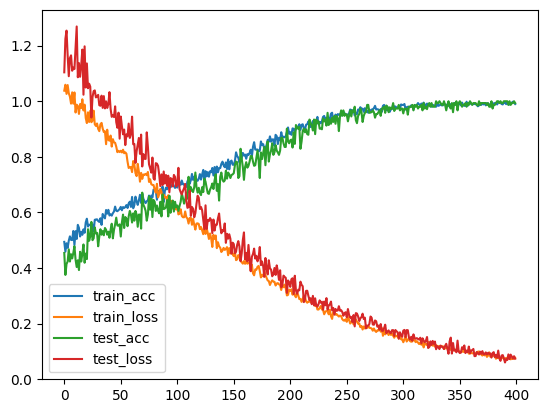

In [23]:
plt.plot(model_results['train_acc'], label='train_acc')
plt.plot(model_results['train_loss'], label='train_loss')
plt.plot(model_results['test_acc'], label='test_acc')
plt.plot(model_results['test_loss'], label='test_loss')
plt.legend()
plt.show